In [1]:
import numpy as np
import pickle
import sys
import os
from scipy import io as spio
import matplotlib.pyplot as plt

import keras


#Sklearn
from sklearn.model_selection import KFold

#Keras import 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.losses import categorical_crossentropy


Using TensorFlow backend.


In [2]:
BYCLASS_PATH =  "../datasets/emnist/matlab/emnist-byclass.mat"
DIGITS_PATH  = "../datasets/emnist/matlab/emnist-digits.mat"


In [4]:
#For byclass 
num_class = 62
#For digits
# num_class = 10

#Load the data
# emnist = spio.loadmat(DIGITS_PATH)

#Load the byclass data
emnist = spio.loadmat(BYCLASS_PATH)

#Load train
x_train = emnist["dataset"][0][0][0][0][0][0]
# x_train = x_train.astype(np.float32)
# x_train = x_train/255

#Load label train
y_train = emnist["dataset"][0][0][0][0][0][1]

#Load test
x_test = emnist["dataset"][0][0][1][0][0][0]
# x_test = x_test.astype(np.float32)
# x_test = x_test/255

#Load label test
y_test = emnist["dataset"][0][0][1][0][0][1]

#Reshaping


x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

x = x.astype(np.float32)
x = x/255

x = x.reshape(x.shape[0], 28,28,1, order = 'A')
y = keras.utils.to_categorical(y, num_class)
# x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order = "A")
# x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order = "A")

# #Convert to categorical
# y_train = keras.utils.to_categorical(y_train, num_class)
# y_test = keras.utils.to_categorical(y_test, num_class)

In [5]:
print(x.shape)
print(y.shape)

(814255, 28, 28, 1)
(814255, 62)


(28, 28, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

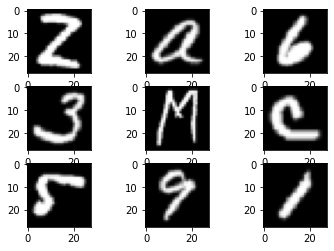

In [6]:
print(x[0].shape)
# plt.imshow(x_train[0][0], cmap='gray')

#show images 
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x[i][:,:,0], cmap=plt.get_cmap('gray'))
    print(y[i])
plt.show()

In [7]:
#Build the model


def create_model_1(num_class, input_shape):
    model = Sequential(
    [
        Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
        Conv2D(64, (3,3), activation='relu'),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_class, activation='softmax')
    ])
    
    model.compile(optimizer = Adadelta(), loss=categorical_crossentropy,\
                 metrics=['accuracy'])
    
    return model
    


In [9]:
#For digits
input_shape = (28,28,1)
batch_size = 128
epochs = 2

#Evaluate the model
kfold = KFold(n_splits = 2, random_state = 3, shuffle=True)

loss_array =[]
accuracy_array = []

for train_index, test_index in kfold.split(x_train):
    model = create_model_1(num_class, input_shape)
    x_train = x[train_index]
    y_train = y[train_index]
    
    x_test = x[test_index]
    y_test = y[test_index]
    
    model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1)
    
    score = model.evaluate(x_test, y_test, verbose = 0)
    
    loss_array.append(score[0])
    accuracy_array.append(score[1])
    
    
print("Mean loss: ", np.mean(loss_array))
print("Std loss: ", np.std(loss_array))

print("Mean accuracy: ", np.mean(accuracy_array))
print("Std accuracy: ", np.std(accuracy_array))
    

Epoch 1/2
174483/174483 [==============================] - 219s 1ms/step - loss: 1.0894 - accuracy: 0.6932
Epoch 2/2
174483/174483 [==============================] - 219s 1ms/step - loss: 0.6571 - accuracy: 0.7914
Epoch 1/2
174483/174483 [==============================] - 241s 1ms/step - loss: 1.0559 - accuracy: 0.7021
Epoch 2/2
174483/174483 [==============================] - 291s 2ms/step - loss: 0.6354 - accuracy: 0.7966
Mean loss:  0.4980300682390313
Std loss:  0.019957980106189016
Mean accuracy:  0.8279803693294525
Std accuracy:  0.008880525827407837
